# Исследование объявлений о продаже квартир

Используем данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Задача: выполнить предобработку данных и изучить их, 
чтобы найти интересные особенности и зависимости, которые существуют на рынке недвижимости. Для выполнения проект выполним следующие этапы:
1.Постановка задачи
2.Получение данных
3.Предобработка данных
4.Анализ данных
5.Оформление результатов**

    total_images  last_price  total_area first_day_exposition  rooms  \
0             20  13000000.0      108.00  2019-03-07T00:00:00      3   
1              7   3350000.0       40.40  2018-12-04T00:00:00      1   
2             10   5196000.0       56.00  2015-08-20T00:00:00      2   
3              0  64900000.0      159.00  2015-07-24T00:00:00      3   
4              2  10000000.0      100.00  2018-06-19T00:00:00      2   
5             10   2890000.0       30.40  2018-09-10T00:00:00      1   
6              6   3700000.0       37.30  2017-11-02T00:00:00      1   
7              5   7915000.0       71.60  2019-04-18T00:00:00      2   
8             20   2900000.0       33.16  2018-05-23T00:00:00      1   
9             18   5400000.0       61.00  2017-02-26T00:00:00      3   
10             5   5050000.0       39.60  2017-11-16T00:00:00      1   
11             9   3300000.0       44.00  2018-08-27T00:00:00      2   
12            10   3890000.0       54.00  2016-06-30T00:00:00   

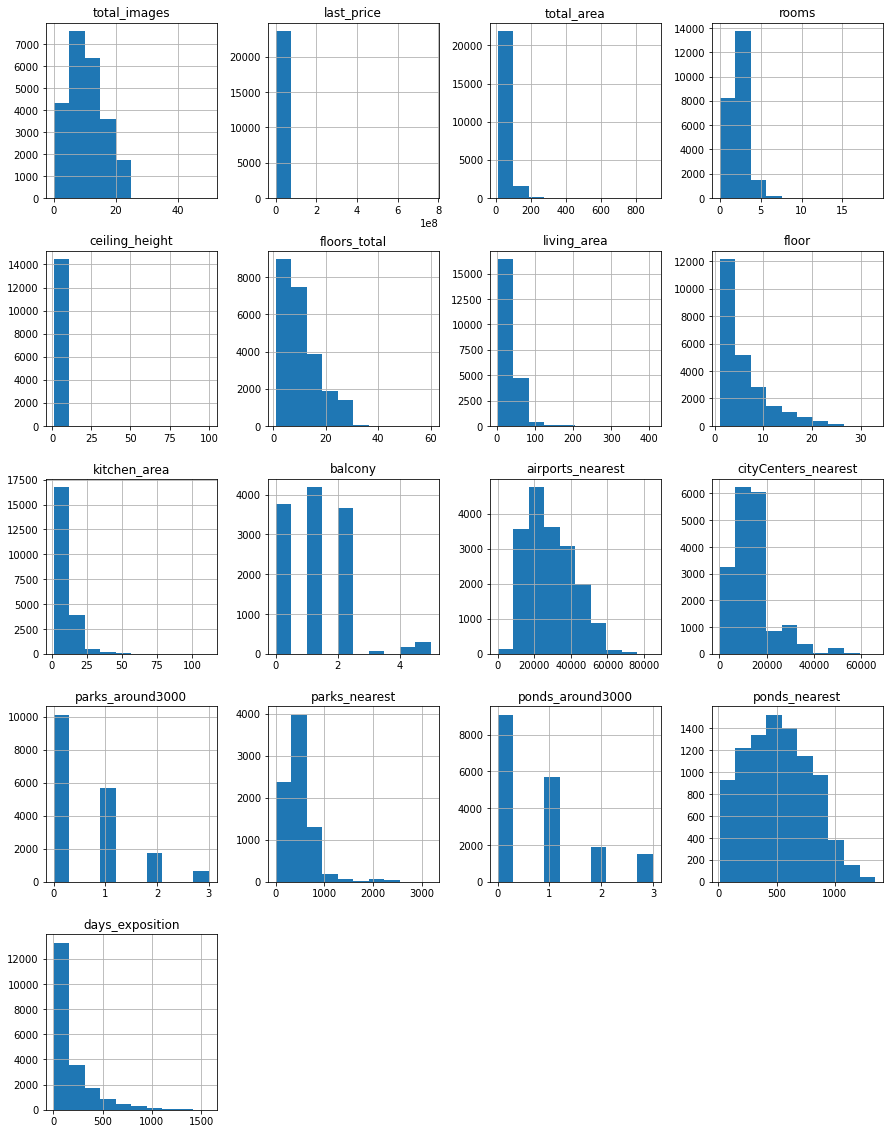

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') # прочитаем csv-файл с разделителем
print(data.head(20))
data.hist(figsize=(15, 20));

### Предобработка данных

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
print(data.duplicated().sum())

0


**Дубликатов не обнаружено**

In [4]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


**Значительные пропуски (больше 50%) присутствуют в столбцах parks_nearest, ponds_nearest,is_apartment**

In [5]:
data.isna().sum()
data['days_exposition'] = data['days_exposition'].fillna(0) #заменим пропуски в days_exposition на 0
data['balcony'].value_counts()
data['balcony'] = data['balcony'].fillna(0) #заменим пропуски в balcony на 0
data['ceiling_height'].sort_values()
data['ceiling_height'].value_counts()
data['ceiling_height'].describe()
data.loc[data['ceiling_height'] >= 22, 'ceiling_height'] = data['ceiling_height'] / 10 
data['is_apartment'] = data['is_apartment'].fillna(False) #заменим пропуски в is_apartment на False
data.groupby(['floors_total'])['ceiling_height'].median()
data['median_height'] = data['ceiling_height'].fillna(data.groupby('floors_total')['ceiling_height'].transform('median'))
data = data[pd.notnull(data['floors_total'])]

In [6]:
data['balcony'] = data['balcony'].astype('int64')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['floors_total'] = data['floors_total'].astype('Int64', errors='ignore')
data['days_exposition'] = data['days_exposition'].astype('int64')
data['last_price'] = data['last_price'].astype('int64');


**Считаю, что потолки выше 22 метров заполнены с ошибкой, пропущена запятая. поэтому разделили на 10, Пропуски в is_apartment заменили на False, думаю если квартира не студия это поле просто пропускают
ceiling_height заменили медианой этажей в домах с таким же количеством этажей**

**Я думаю, что тип данных "Дата публикации" лучше изменть на дату, так как времени нет. Тип данных в поле "Апартаменты" на бул, так как поле подразумевает 2 значения правда или ложь. Тип данных в столбцах "Балкон" и "Всего этажей" изменили, чтобы отбрость нули после запятой, так будет удобнее. "Сколько дней было размещено объявление" изменили тип так как это целое цисло**

In [7]:
def categorize_locality_name (row):
    try:
        if 'гор' in row and 'пос' in row:
            return 'Поселок городского типа'
        elif 'котт' in row and 'пос' in row:
            return 'Коттеджный поселок'
        elif 'село' in row:
            return 'Село'
        elif 'дер' in row:
            return 'Деревня'
        elif 'пос' in row:
            return 'Поселок'
        return'Город' 
    except:
        return 'Нет категории'
data['categorize_locality_name'] = data['locality_name'].apply(categorize_locality_name)
data.head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_height,categorize_locality_name
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0,2.70,Город
1,7,3350000,40.40,2018-12-04,1,NaN,11,18.60,1,False,...,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,2.75,Поселок
2,10,5196000,56.00,2015-08-20,2,NaN,5,34.30,4,False,...,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,2.55,Город
3,0,64900000,159.00,2015-07-24,3,NaN,14,NaN,9,False,...,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424,2.60,Город
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,3.03,Город
5,10,2890000,30.40,2018-09-10,1,NaN,12,14.40,5,False,...,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55,2.65,Поселок городского типа
6,6,3700000,37.30,2017-11-02,1,NaN,26,10.60,6,False,...,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155,2.66,Поселок
7,5,7915000,71.60,2019-04-18,2,NaN,24,NaN,22,False,...,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,0,2.75,Город
8,20,2900000,33.16,2018-05-23,1,NaN,27,15.43,26,False,...,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189,2.70,Поселок
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.60,7,False,...,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289,2.50,Город


**В 14 столбцах есть пропущенные значения. Большее количество пропусков в столбцах: Балкон, Расстояние до ближайшего водоёма и Расстояние до ближайшего парка. Пропуски могли появиться в результате технического сбоя, т.к. данные картографические, такие данные оставлю без изменений. 
А вот пропущенные значения в столбце балконы заменили значением 0, скорее всего не заполнили значение, потому что балкона нет.
После того как, исправили выбивающиеся значения в столбце "ceiling_height" значения заполнили медианой среди домов такой же этажностью и записали в новый столбец "median_height". Эти показатели важны для анализа.**

### Посчитайте и добавьте в таблицу новые столбцы

In [8]:
data['price_square_meter'] = data['last_price'] / data['total_area'] #цена одного квадратного метра
data['week_day'] = data['first_day_exposition'].dt.weekday #день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
data['month_exposition'] = data['first_day_exposition'].dt.month #месяц публикации объявления
data['year_exposition'] = data['first_day_exposition'].dt.year #год публикации объявления
;

''

In [9]:
#тип этажа квартиры (значения — «первый», «последний», «другой»)
def floor_categ(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'
    
data['floor_categ'] = data.apply(floor_categ, axis = 1)
print (data['floor_categ'])
;

0        другой
1        первый
2        другой
3        другой
4        другой
          ...  
23694    другой
23695    другой
23696    первый
23697    другой
23698    первый
Name: floor_categ, Length: 23613, dtype: object


''

In [10]:
#расстояние до центра города в километрах
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000)
print (data['cityCenters_nearest_km'])

0        16.0
1        19.0
2        14.0
3         7.0
4         8.0
         ... 
23694     4.0
23695     NaN
23696     NaN
23697    10.0
23698     NaN
Name: cityCenters_nearest_km, Length: 23613, dtype: float64


### Проведите исследовательский анализ данных

count    23613.000000
mean        60.340678
std         35.648988
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

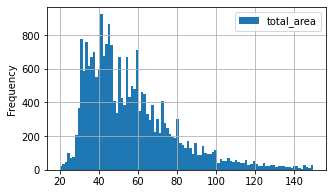

In [11]:
data.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (20,150)) #Изучим общую площадь
data['total_area'].describe()

**Распределение нормальное, есть выбросы но они не значительные** 

count    21743.000000
mean        34.462781
std         22.037433
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

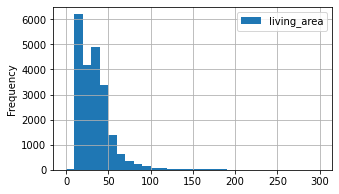

In [12]:
data.plot(y = 'living_area', kind = 'hist', bins = 30, grid=True, figsize = (5,3), range = (0,300)) #Изучим жилую площадь
data['living_area'].describe()

**Распределение нормальное, есть выбросов практически нет** 

count    21382.000000
mean        10.564128
std          5.904316
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

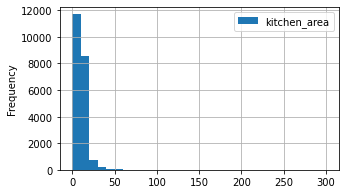

In [13]:
data.plot(y = 'kitchen_area', kind = 'hist', bins = 30, grid=True, figsize = (5,3), range = (0,300)) #Изучим площадь кухни
data['kitchen_area'].describe()

**Данные в порядке, выбросов практически нет** 

count    2.361300e+04
mean     6.540555e+06
std      1.090172e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

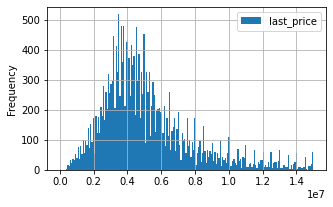

In [14]:
data.plot(y = 'last_price', kind = 'hist', bins = 200, grid=True, range = (0,15000000), figsize = (5,3)) #Изучим цену
data['last_price'].describe()

**Данные в порядке**

count    23613.000000
mean         2.071147
std          1.078380
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

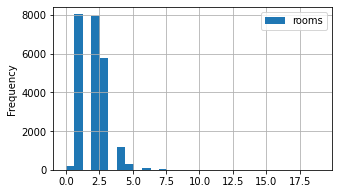

In [15]:
data.plot(y = 'rooms', kind = 'hist', bins = 30, grid=True, figsize = (5,3)) #изучим число комнат
data['rooms'].describe()

**Данные в порядке** 

count    14495.000000
mean         2.730820
std          0.350571
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         20.000000
Name: ceiling_height, dtype: float64

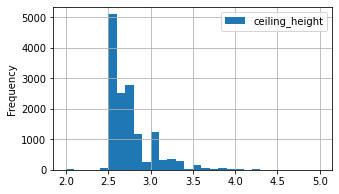

In [16]:
data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,5), grid=True, figsize = (5,3))
data['ceiling_height'].describe()

**Данные в порядке** 

count    23613.000000
mean         5.877313
std          4.873539
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

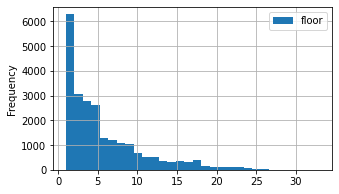

In [17]:
data.plot(y = 'floor', kind = 'hist', bins = 30, grid=True, figsize = (5,3))
data['floor'].describe()

**Данные в порядке**

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

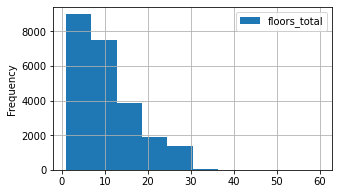

In [18]:
data.plot(y = 'floors_total', kind = 'hist', bins = 10, grid=True, figsize = (5,3))
data['floors_total'].describe()

**Данные в порядке, выбросов практически нет** 

<AxesSubplot:>

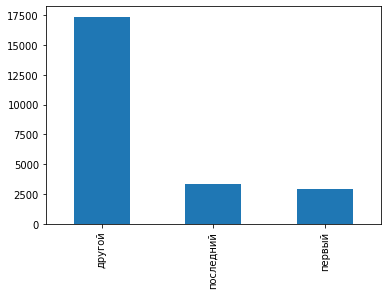

In [19]:
data['floor_categ'].value_counts().plot.bar()

count    18104.000000
mean     14185.084015
std       8614.132292
min        181.000000
25%       9233.750000
50%      13093.000000
75%      16287.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

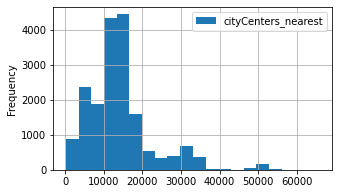

In [20]:
data.plot(y = 'cityCenters_nearest', kind = 'hist', bins = 20, grid=True, figsize = (5,3))
data['cityCenters_nearest'].describe()

**Растояние до центра в среднем 14191 метр, есть выбросы**

count    18081.000000
mean     28788.008185
std      12626.209956
min          0.000000
25%      18575.000000
50%      26726.000000
75%      37242.000000
max      84869.000000
Name: airports_nearest, dtype: float64

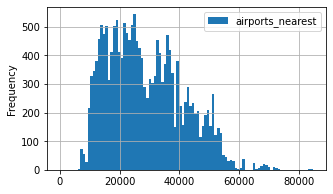

In [21]:
data.plot(y = 'airports_nearest', kind = 'hist', bins = 100, grid=True, figsize = (5,3))
data['airports_nearest'].describe()

**В среднем растояние до аэропорта 28700 м**

count    8045.000000
mean      490.554630
std       341.336698
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

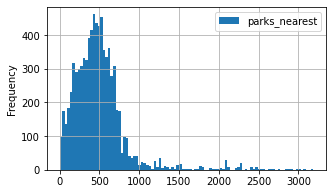

In [22]:
data.plot(y = 'parks_nearest', kind = 'hist', bins = 100, grid=True, figsize = (5,3))
data['parks_nearest'].describe()

**В сренем рассояние до ближайшего парка 490м**

count    23613.000000
mean         6.400076
std          3.493160
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_exposition, dtype: float64

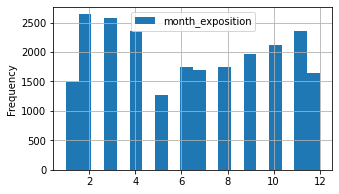

In [23]:
data.plot(y = 'month_exposition', kind = 'hist', bins = 20, grid=True, figsize = (5,3)) #изучим месяц публикации объявления.
data['month_exposition'].describe()

**Выбросов нет, данные в порядке**

count    23613.000000
mean         2.568035
std          1.788565
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: week_day, dtype: float64

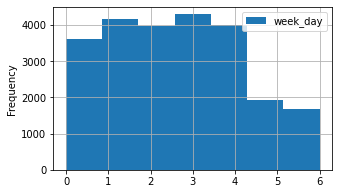

In [24]:
data.plot(y = 'week_day', kind = 'hist', bins = 7, grid=True, figsize = (5,3)) #Изучим день недели публикации объявления.
data['week_day'].describe()

**Выбросов практически нет.**

0       3172
45       880
60       538
7        234
30       208
        ... 
1112       1
1080       1
1064       1
1032       1
1391       1
Name: days_exposition, Length: 1140, dtype: int64

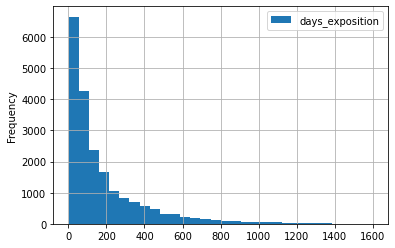

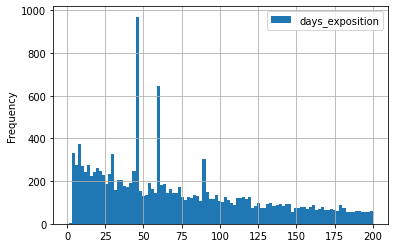

In [25]:
data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600), label='days_exposition')
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,200), label='days_exposition')
#data['days_exposition'].describe() #выведем среднее значение и медиану
data['days_exposition'].value_counts()


**Среднее значение - 177 дней, а медиана - 98 дней.  Построили гистограму со значениями от 0 до 200 и количеством корзин 300, заметили выбросы. Далее посмотрели часто повторяющиеся значения выбросов: 7,30,45,60. Возможно в эти дни обьявления снимают с публикации автоматически**

0.6535810085611219

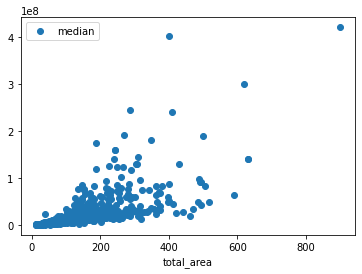

In [26]:
#зависит ли цена от общей площади
pivot_table_total_area = data.pivot_table(index = 'total_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')
pivot_table_total_area.sort_values('median', ascending = False)
data['total_area'].corr(data['last_price'])

**Чем больше площадь тем выше стоимость, особенно это прослеживается в квартирах с площадью больше 350 кв.м**

0.5663955721081748

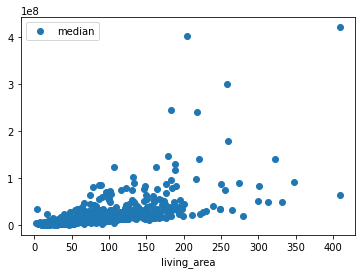

In [27]:
#зависит ли цена от жилой площади
pivot_table_total_area = data.pivot_table(index = 'living_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')
pivot_table_total_area.sort_values('median', ascending = False)
data['living_area'].corr(data['last_price'])

**Кореляция и график говорят, что чем больше площадь жилой комнаты, тем больше цена квартры.**

0.5200184586898168

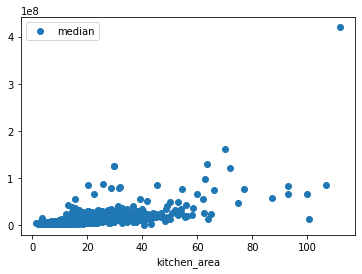

In [28]:
#зависит ли цена от площади кухни
pivot_table_total_area = data.pivot_table(index = 'kitchen_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')
pivot_table_total_area.sort_values('median', ascending = False)
data['kitchen_area'].corr(data['last_price'])

**Судя по графику видно завистимость цены от площади кухни, корреляция говорит о том, чем больше площадь кухни тем немного выше цена**

,mean,count,median
rooms,,,
0,3.344493e+06,194,2700000
1,3.835157e+06,8015,3600000
2,5.588244e+06,7913,4768714
3,8.172670e+06,5795,6200000
4,1.340960e+07,1177,9000000
5,2.379830e+07,325,14000000
6,3.188004e+07,104,19000000
7,5.147007e+07,59,24900000
8,5.022417e+07,12,23095000


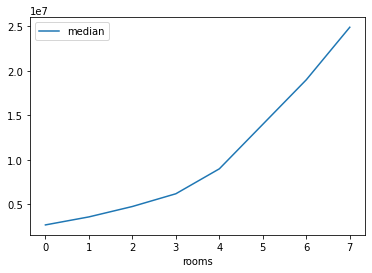

In [29]:
#зависит ли цена от количества комнат
pivot_table_rooms = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_rooms.columns = ['mean', 'count', 'median']
pivot_table_rooms.query('count > 50').plot(y = 'median')
pivot_table_rooms.query('count > 50').sort_values('median', ascending = False)
data['rooms'].corr(data['last_price'])

pivot_table_rooms

**Чем больше комнат, тем дороже квартира, все логично. но корреляуия достаточно слабая. Думаю что тут лучше бы посмотреть зависимость стоимости квадратного метра и количества комнат**

,mean,count,median
floor_categ,,,
другой,6.674074e+06,17363,4850000
первый,4.805699e+06,2914,3900000
последний,7.361025e+06,3336,4300000


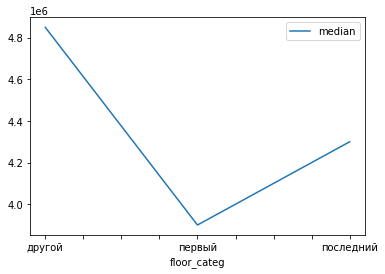

In [30]:
#зависит ли цена от этажа
pivot_table_floor_categ = data.pivot_table(index = 'floor_categ', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_floor_categ.columns = ['mean', 'count', 'median']
pivot_table_floor_categ.plot(y = 'median')
display(pivot_table_floor_categ)

**Судя по графику чем выше этаж тем дороже стоимость квартиры, возможно это связанно с красивыми видами из окна**

,mean,count,median
week_day,,,
1,6.390112e+06,4170,4725000
2,6.631800e+06,3956,4700000
0,6.519120e+06,3602,4650000
3,6.703666e+06,4285,4650000
4,6.367272e+06,3988,4577500
5,6.980411e+06,1922,4550000
6,6.238971e+06,1690,4540000


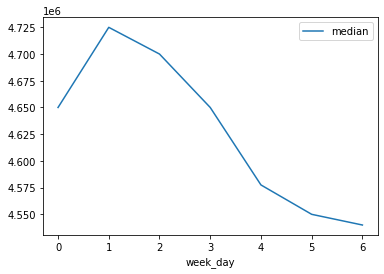

In [31]:
#зависит ли цена от дня недели
pivot_table_week_day = data.pivot_table(index = 'week_day', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_week_day.columns = ['mean', 'count', 'median']
pivot_table_week_day.plot(y = 'median')
pivot_table_week_day.sort_values('median', ascending = False)

**Обьявления выставленные в четверг по стоимости выше остальных, а в воскресенье самая низкая стоимость. Думаю в воскресенье люди не так активны и спрос на квартиры падает, а в четверг перед выходными цены поднимают потому, что растет спрос.**

,mean,count,median
month_exposition,,,
4,6.737882e+06,2362,4800000
9,6.835426e+06,1974,4700000
11,6.449008e+06,2364,4700000
12,7.011731e+06,1641,4700000
2,6.467983e+06,2637,4650000
3,6.356274e+06,2580,4650000
7,6.648568e+06,1690,4650000
1,6.665449e+06,1496,4600000
8,6.343181e+06,1741,4570000


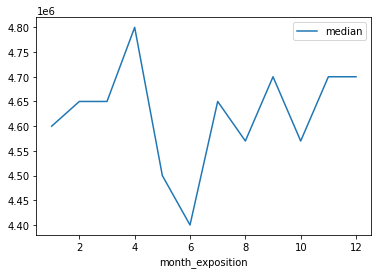

In [32]:
#Зависит ли цена от месяца
pivot_table_month = data.pivot_table(index = 'month_exposition', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_month.columns = ['mean', 'count', 'median']
pivot_table_month.plot(y = 'median')
pivot_table_month.sort_values('median', ascending = False)


**В мае и июне обьявления с самой низкой ценой, возможно не самый популярные месяцы для покупки квартир, а вот в апреле цена самая высокая**

,mean,count,median
year_exposition,,,
2014,1.208714e+07,137,7700000
2015,8.575612e+06,1184,5312500
2019,6.779324e+06,2871,5050000
2016,6.827605e+06,2763,4550000
2018,5.952940e+06,8492,4550000
2017,6.582439e+06,8166,4500000


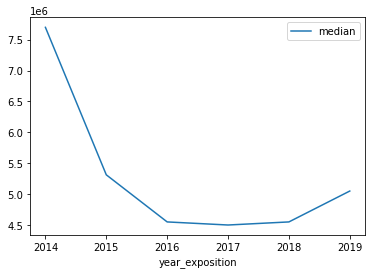

In [33]:
#Зависит ли цена от года
pivot_table_year = data.pivot_table(index = 'year_exposition', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_year.columns = ['mean', 'count', 'median']
pivot_table_year.plot(y = 'median')
pivot_table_year.sort_values('median', ascending = False)

**Интересный график, мы видим как стоимость квартир уменьшаласьс 2014 до 2017 года, а после стоимость плавно пошла вверх**

,mean,count,median
living_area,,,
409.70,420000000.0,1,420000000.0
204.00,401300000.0,1,401300000.0
258.00,300000000.0,1,300000000.0
182.80,245000000.0,1,245000000.0
218.00,240000000.0,1,240000000.0
...,...,...,...
16.31,1700000.0,1,1700000.0
18.11,1695000.0,2,1695000.0
12.81,1690715.0,1,1690715.0


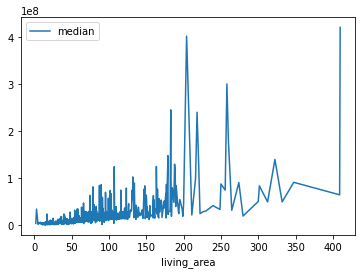

In [34]:
#рассмотрим динамику цены и площади продаваемых квартир
pivot_table_living_area = data.pivot_table(index = 'living_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_living_area.columns = ['mean', 'count', 'median']
pivot_table_living_area.plot(y = 'median')
pivot_table_living_area.sort_values('median', ascending = False)

<AxesSubplot:xlabel='year_exposition'>

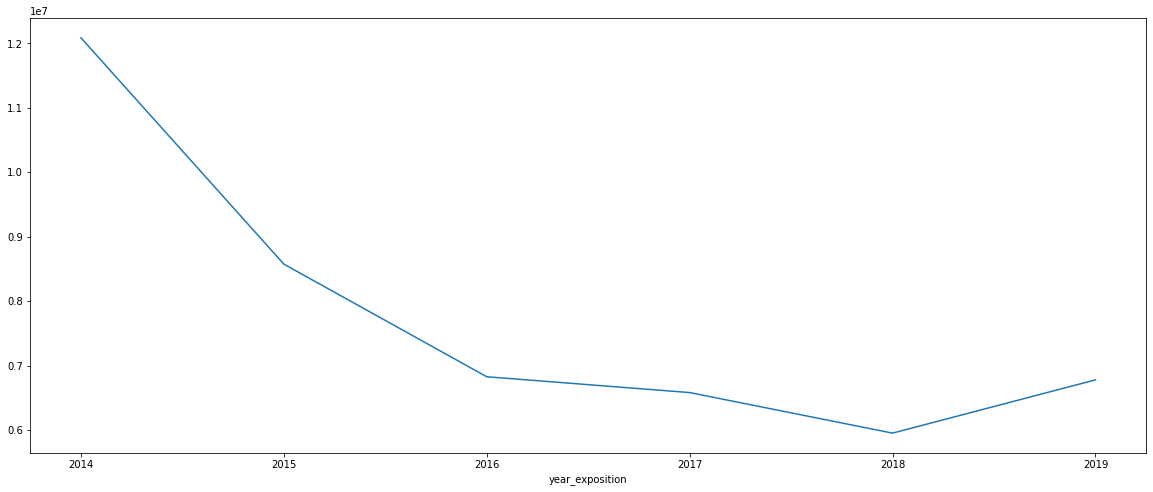

In [35]:
data.groupby('year_exposition')['last_price'].mean().plot(figsize = (20, 8))

<AxesSubplot:xlabel='year_exposition'>

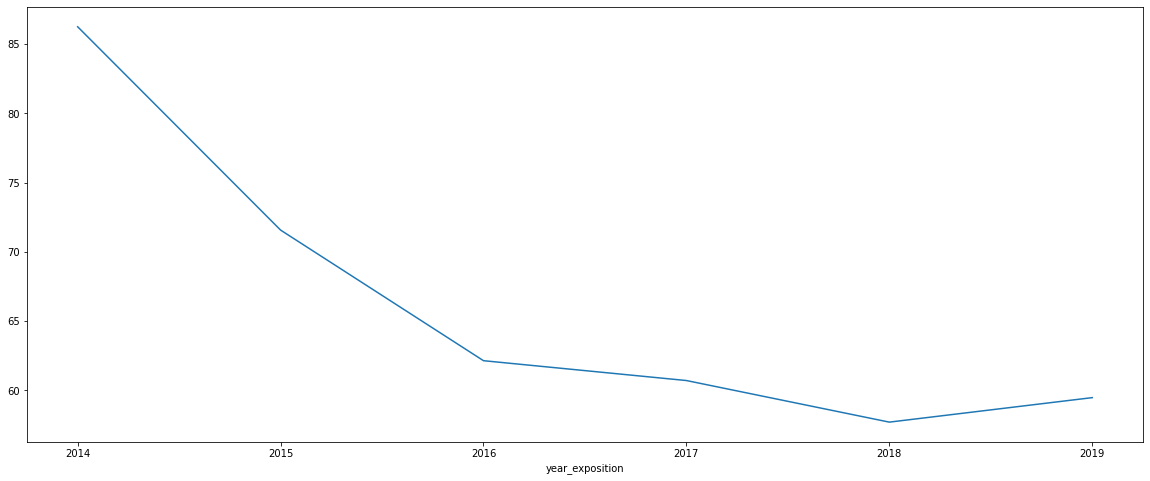

In [36]:
data.groupby('year_exposition')['total_area'].mean().plot(figsize = (20, 8))

In [37]:
locality_pivot_table = data.pivot_table(index = 'locality_name', values = 'price_square_meter', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean'] 
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
print(locality_pivot_table)
#locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()] #самая высокая стоимость
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()] #самая низкая стоимость

                   count           mean
locality_name                          
Санкт-Петербург    15651  114868.877341
посёлок Мурино       520   85673.259928
посёлок Шушары       439   78551.344545
Всеволожск           398   68654.473986
Пушкин               369  103125.819291
Колпино              338   75424.579098
посёлок Парголово    327   90175.913458
Гатчина              307   68746.146763
деревня Кудрово      299   92473.547576
Выборг               237   58141.909153


,count,mean
locality_name,,
Выборг,237,58141.909153


**Из 10 населенных пунктов с самым большим числом обьявлений самая высокая стоимость за квадратный метр в Санкт_Петербурге, а самая низкая в Выборге**

,price_square_meter
cityCenters_nearest_km,
0,245833.530289
1,177005.407676
2,157849.007329
3,121507.831586
4,133282.874761
5,140453.957043
6,151012.193621
7,156176.879664
8,125649.733020


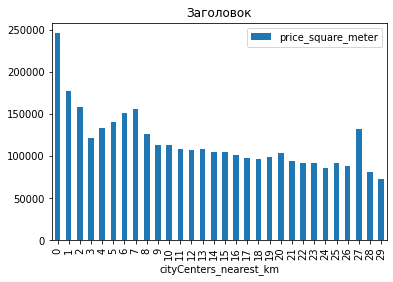

In [38]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].astype('Int64', errors='ignore')
data = data[pd.notnull(data['cityCenters_nearest_km'])]
km_pivot_table = data.query('locality_name == "Санкт-Петербург"')\
    .pivot_table(index = 'cityCenters_nearest_km', values = 'price_square_meter', aggfunc = 'mean')
display(km_pivot_table)
km_pivot_table.plot.bar(title = 'Заголовок') 
plt.show()

**Чем ближе к центру, тем цены за квадратный метр дороже, но на 4-7 км и на 27 км квартиры дороже, чем на 3 км. Возможно рядом присутствуют достопримеательности или это новые районы**

### Общий вывод

**Выполнилнела переработку данных,заполнила пусые знаяения, где возможно, изменила типы данных. Посчитала цену квадратного метра жилья,создала категории этажей. Изучила следующие параметры на наличие выбивающихся значений:
общая площадь;
жилая площадь;
площадь кухни;
цена объекта;
количество комнат;
высота потолков;
этаж квартиры;
тип этажа квартиры («первый», «последний», «другой»);
общее количество этажей в доме;
расстояние до центра города в метрах;
расстояние до ближайшего аэропорта;
расстояние до ближайшего парка;
день и месяц публикации объявления.
Выявила, что на стоимость квартиры больше всего влияют количество комнат, цена квартиры, этаж квартиры. Незначительно на стоимость квадратного метра влияют близость к центру, день, месяц, год размещения и общая площадь, и площадь кухни. Выяснила, что самая высокая цена за квадратный метр в Санкт_Петербурге, а самая низкая в Выборге.**